In [85]:
import math
import numpy as np
from graphviz import Digraph

In [7]:
# Understanding derivatives
a = 2.0
b = -3.0
c = 10.0

h = 0.001
d1 = a*b + c
a += h
d2 = a*b + c
slope = (d2-d1)/h
print(slope)
a*b + c

-3.0000000000001137


3.997

In [111]:
# Class Value with operator overloading
class Value:
    def __init__(self, value, _previous=(), _operation="", label="", gradient=0):
        self.value = value
        self._previous = set(_previous)
        self._operation = _operation
        self._backward = lambda: None
        self.gradient = gradient
        self.label = label
    def __repr__(self):
        return f"Value({self.value})"
    def __add__(self, other):
        output = Value(self.value + other.value, (self, other), "+")
        def _backward():
            self.gradient = output.gradient
            other.gradient = output.gradient
        output._backward = _backward
        return output
    def __mul__(self, other):
        output = Value(self.value * other.value, (self, other), "*")
        def _backward():
            self.gradient = other.value * output.gradient
            other.gradient = self.value * output.gradient
        output._backward = _backward
        return output
    def tanh(self):
        t = (math.exp(2*self.value) - 1)/(math.exp(2*self.value) + 1)
        output = Value(t, (self, ), 'tanh')
        def _backward():
            self.gradient = (1 - t**2) * output.gradient
        output._backward = _backward
        return output

# Building the expression 
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a*b
d.label = "d"
e = d + c
e.label = "e"
f = Value(-2.0, label="f")
L = e*f; L.label = "L"

# Calculate manually the gradient at each node compared to L (the loss function)
h = 0.0001
L.gradient = 1.0  # ((L.value + h) - L.value)/h 
f.gradient = 4.0  # L=d*f, dL/df=e, e=4.0 ∴ dL/df = 4.0
e.gradient = -2.0 # L=d*f, dL/de=f, f=-2.0 ∴ dL/de = -2.0
c.gradient = -2.0 # dL/dc = dL/de * de/dc (chain rule), de/dc = 1.0, ∴ dL/dc = -2.0 * 1.0 = 2.0
d.gradient = -2.0 # dL/dd = dL/de * de/dc (chain rule), de/dc = 1.0, ∴ dL/dc = -2.0 * 1.0 = 2.0
b.gradient = -4.0  # dL/db = dL/de * de/dc * dc/db = -2.0 * 1.0 * 2.0 = -4.0 ∴ dL/db = 4.0
a.gradient = 6.0  # dL/da = dL/de * de/dc * dc/da = -2.0 * 1.0 * -3.0 = 6.0 ∴ dL/db = 6.0

# Add "h" to the respective node and see how it calculates the resulting gradient
def calculateLGradient():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    e.label = "d"
    d = e + c
    d.label = "e"
    f = Value(-2.0, label="f")
    L1 = d*f; L1.label = "L1"
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    e.label = "d"
    d = e + c
    d.label = "e"
    f = Value(-2.0, label="f")
    L2 = d*f; L2.label = "L2"

    print((L2.value-L1.value)/h)
    
calculateLGradient()
# TODO: 

0.0


In [76]:
# Nudge the leaf ndoes and see how it affects the loss function
nudge = 0.01
a.value += a.gradient * nudge
b.value += b.gradient * nudge
c.value += c.gradient * nudge
f.value += f.gradient * nudge

d = a * b
e = d + c
L = f * e

print(L)

Value(-7.286496)


In [60]:
# Visualize above graph
# Copied code from https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._previous:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | value %.4f | grad %.4f }" % (n.label, n.value, n.gradient), shape='record')
        if n._operation:
            dot.node(name=str(id(n)) + n._operation, label=n._operation)
            dot.edge(str(id(n)) + n._operation, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    
    return dot

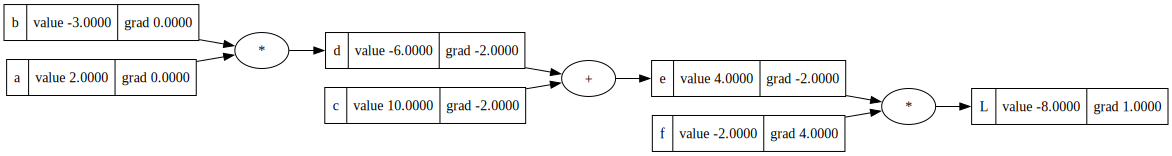

In [67]:
draw_dot(L)

In [106]:
# Calculate a more complex expression that mimics a neural network

# Activation function tanh

# Expression
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# sum of all the weights
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ="x1w1x2w2"

n = x1w1x2w2 + b; n.label = "x1w1x2w2 + b"
o = n.tanh(); o.label = "o"


In [ ]:
# Calculate gradient manually
o.gradient = 1.0  # base case
n.gradient = 0.5  # do/dn = 1 - tanh(o)**2 = 1 - 0.707**2 = 0.5
b.gradient = 0.5
x1w1x2w2.gradient = 0.5
x1w1.gradient = 0.5
x2w2.gradient = 0.5
w2.gradient = 0
x2.gradient = 0.5
w1.gradient = 1.0
x1.gradient = -1.5

In [112]:
# Calulate gradient by using backward propegation
o.gradient = 1.0
o._backward()
n._backward()

NameError: name 'out' is not defined

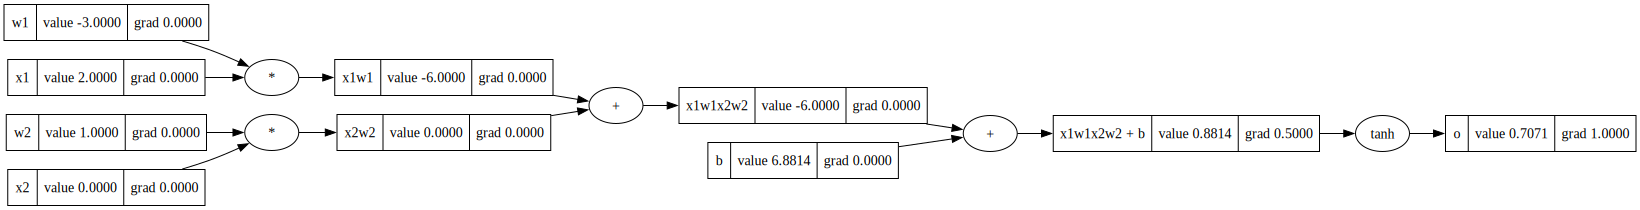

In [109]:
draw_dot(o)